In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu118 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch==2.0.1+cu118


In [1]:
import os
import csv
import torch
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.utils.data import Dataset
from transformers import CLIPTextModelWithProjection, CLIPTokenizer
from diffusers import DiffusionPipeline,StableDiffusionPipeline, EulerDiscreteScheduler, UNet2DConditionModel
from accelerate import Accelerator

c:\Users\precision\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
manual_seed = 42

In [3]:
# Definitions
torch.cuda.empty_cache()  #doesn't work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device).manual_seed(manual_seed)
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModelWithProjection.from_pretrained(model_id, subfolder="text_encoder")

pipe = DiffusionPipeline.from_pretrained(
    model_id, 
    scheduler=scheduler,
    unet=unet,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    torch_dtype=torch.float,
    use_safetensors=True,
)

pipe.to(device)

c:\Users\precision\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CLIPTextModelWithProjection were not initialized from the model checkpoint at stabilityai/stable-diffusion-xl-base-1.0 and are newly initialized: ['text_projection.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 18.43it/s]


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Fine-tuning

In [ ]:
# Training script

accelerator = Accelerator()

model, optimizer, training_dataloader, scheduler = accelerator.prepare(
     model, optimizer, training_dataloader, scheduler
  )

for batch in training_dataloader:
    optimizer.zero_grad()
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()

## Image generation

In [4]:
def save_image_with_metadata(image, metadata, directory='images'):
    """
    Save an image in a directory with an auto-incrementing filename and save metadata to a CSV file.

    :param image: Image to save.
    :param metadata: Dictionary containing metadata about the image.
    :param directory: Directory to save the image and metadata.
    """
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Create a CSV file for metadata if it doesn't exist
    csv_filepath = os.path.join(directory, 'metadata.csv')
    file_exists = os.path.isfile(csv_filepath)

    # Check if the metadata already exists
    metadata_exists = False
    # Convert all metadata values to strings for comparison
    str_metadata = {k: str(v) for k, v in metadata.items()}
    if file_exists:
        with open(csv_filepath, mode='r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row == str_metadata:
                    metadata_exists = True
                    break

    # Add metadata if it doesn't exist
    if not metadata_exists:
        # Create a filename with an incrementing number
        existing_files = sorted([f for f in os.listdir(directory) if f.startswith('image_') and f.endswith('.png')])
        if existing_files:
            last_file = existing_files[-1]
            last_number = int(last_file.split('_')[1].split('.')[0])
            new_number = last_number + 1
        else:
            new_number = 1
        new_filename = f'image_{new_number:04d}.png'
        new_filepath = os.path.join(directory, new_filename)
        # Save the image
        image.save(new_filepath)
        # Save the metadata
        with open(csv_filepath, mode='a', newline='') as csvfile:
            fieldnames = metadata.keys()
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            if not file_exists:
                writer.writeheader()
            writer.writerow(metadata)
        print(f"Image saved as {new_filepath} with metadata.")
    else:
        print("Image already saved with metadata.")

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Image saved as outputs/stabilityai/stable-diffusion-xl-base-1.0/image_0006.png with metadata.


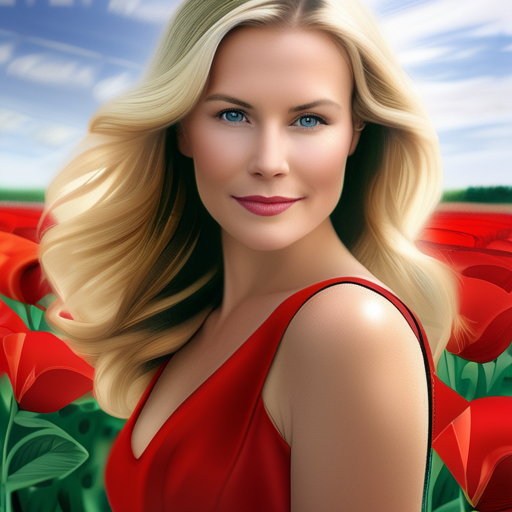

In [9]:
params = {
    "prompt": "A photorealistic portrait of a beautiful young blond woman in her thirties wearing a red dress and high heels. She is standing in a field of flowers.",
    "negative_prompt": "abstract cartoon character violence nudity blood gore male",
    "height":  512,
    "width": 512,
    "num_inference_steps": 100,
    "guidance_scale": 7,
    "generator": generator,
}
output_directory = f"outputs/{model_id}/"
images = pipe(**params).images
image = images[0]
metadata = params.copy()
metadata.update({"generator_seed": metadata.pop("generator").initial_seed()})
save_image_with_metadata(image, metadata, directory=output_directory)
image